# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [1]:
"""
import os
import string

# 定义源目录路径
source_dir = "EnglishImg/English/Img/GoodImg/Bmp"

# 生成目标文件夹名称列表
target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]

# 获取源目录下的所有文件夹名称
source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])

# 确保源文件夹数量与目标文件夹数量一致
if len(source_folders) != len(target_folders):
    raise ValueError("源文件夹数量与目标文件夹数量不一致")

# 重命名文件夹
for source_folder, target_folder in zip(source_folders, target_folders):
    source_path = os.path.join(source_dir, source_folder)
    target_path = os.path.join(source_dir, target_folder)

    try:
        os.rename(source_path, target_path)
        print(f"重命名: {source_path} -> {target_path}")
    except FileExistsError:
        print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
    except Exception as e:
        print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")
"""




'\nimport os\nimport string\n\n# 定义源目录路径\nsource_dir = "EnglishImg/English/Img/GoodImg/Bmp"\n\n# 生成目标文件夹名称列表\ntarget_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]\n\n# 获取源目录下的所有文件夹名称\nsource_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])\n\n# 确保源文件夹数量与目标文件夹数量一致\nif len(source_folders) != len(target_folders):\n    raise ValueError("源文件夹数量与目标文件夹数量不一致")\n\n# 重命名文件夹\nfor source_folder, target_folder in zip(source_folders, target_folders):\n    source_path = os.path.join(source_dir, source_folder)\n    target_path = os.path.join(source_dir, target_folder)\n\n    try:\n        os.rename(source_path, target_path)\n        print(f"重命名: {source_path} -> {target_path}")\n    except FileExistsError:\n        print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")\n    except Exception as e:\n        print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")\n'

### 划分训练集和测试集

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision import utils
import torchvision.transforms as T
import torch.utils.data as Data
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
#使用tensorboardX进行可视化
from tensorboardX import SummaryWriter
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
#参数定义
EPOCH = 100
BATCH_SIZE = 128
LR = 1e-4
ROOT_DIR = "EnglishImg/English/Img/GoodImg/Bmp"
LOG_DIR = f"runs/handwriting_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
MODEL_SAVE_PATH = "cnn_res_attention_best.pth"

In [3]:
# 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((28, 28)), # 统一尺寸为28x28
#     T.Grayscale(num_output_channels=1), # 灰度处理
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(), # 转换为Tensor
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])

class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(32, 32),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()

# 定义划分数据集的函数
def split_dataset(root_dir, transform, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=128, shuffle=True, random_seed=42):
    """
    划分数据集为训练集、验证集和测试集，并返回对应的DataLoader。

    参数:
    - root_dir: 数据集根目录
    - transform: 数据预处理变换
    - train_ratio: 训练集比例
    - val_ratio: 验证集比例
    - test_ratio: 测试集比例
    - batch_size: 批次大小
    - shuffle: 是否打乱数据
    - random_seed: 随机种子，用于保证结果可重复

    返回:
    - train_loader: 训练集DataLoader
    - val_loader: 验证集DataLoader
    - test_loader: 测试集DataLoader
    - full_dataset: 原始的ImageFolder数据集
    """
    # 确保比例之和为1
    assert train_ratio + val_ratio + test_ratio == 1, "比例之和必须为1"

    # 加载整个数据集
    full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    # 计算每个子集的大小
    dataset_size = len(full_dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # 随机划分数据集
    train_dataset, val_dataset, test_dataset = Data.random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

    # 创建DataLoader
    train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader, test_loader, full_dataset



训练集大小: 5393
验证集大小: 1155
测试集大小: 1157


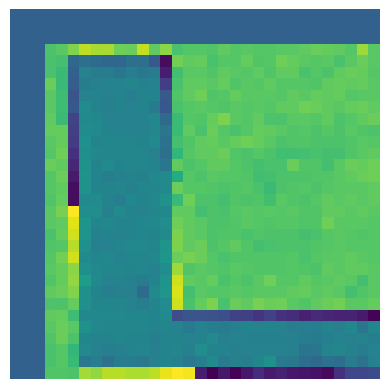

CNN(
  (Conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear): Sequential(
    (0): Linear(in_features=2048, out_features=400, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=80, bias=True)
    (4): ReLU()
    (5): Linear(in_features=80, out_features=62, bias=True)
  )
)


In [4]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)

# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 32, 32]
plt.imshow(a)
plt.axis('off')
plt.show()


# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.Linear = nn.Sequential(
            nn.Linear(32*8*8, 400),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(400, 80),
            nn.ReLU(),
            nn.Linear(80, label_num),
        )

    def forward(self, input):
        input = self.Conv1(input)
        input = self.Conv2(input)
        input = input.view(input.size(0), -1)
        output = self.Linear(input)
        return output

cnn = CNN()
print(cnn)

# 定义优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
# 定义损失函数
loss_func = nn.CrossEntropyLoss()

In [5]:
# 轻量CNN结构？
class SimpleAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels // 2, 1)
        self.conv2 = nn.Conv2d(channels // 2, channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.conv2(attn)
        attn = self.sigmoid(attn)
        return x * attn


In [6]:
# 添加残差模块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_attention=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.attn = SimpleAttention(out_channels) if use_attention else nn.Identity()

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        res = self.shortcut(x)
        out = self.conv(x)
        out = self.attn(out)
        return self.relu(out + res)

In [7]:
# CNN自注意力模块？
class SelfAttention2D(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # 可学习的缩放系数

    def forward(self, x):
        B, C, H, W = x.shape
        proj_q = self.query(x).view(B, -1, H * W)          # B x C1 x N
        proj_k = self.key(x).view(B, -1, H * W)            # B x C1 x N
        proj_v = self.value(x).view(B, -1, H * W)          # B x C  x N

        attention = torch.bmm(proj_q.permute(0, 2, 1), proj_k)  # B x N x N
        attention = torch.softmax(attention, dim=-1)

        out = torch.bmm(proj_v, attention.permute(0, 2, 1))     # B x C x N
        out = out.view(B, C, H, W)

        return self.gamma * out + x

class CNNWithAttention(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 16x16
        )

        self.extra_conv = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU())

        self.block1 = ResidualBlock(32, 64, use_attention=True)
        self.block2 = ResidualBlock(64, 128, use_attention=True)
        self.pool2 = nn.MaxPool2d(2)  # 14x14 → 7x7
        self.block3 = ResidualBlock(128, 128)
        self.attention = SelfAttention2D(128) # 添加自注意力模块

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.extra_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.attention(x)
        return self.classifier(x)



In [8]:
# 训练与验证函数
def train_and_validate(model, train_loader, val_loader, epochs, device='cpu', save_path='best_model.pth', save_best_only=True):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()
    writer = SummaryWriter(log_dir=LOG_DIR)

    best_val_top1_acc = 0.0  # 用于追踪验证集 Top-1 准确率的最佳值

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        top1_correct = 0
        top3_correct = 0
        total = 0

        # --- 训练阶段 ---
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = loss_func(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)

            # Top-1
            _, top1_pred = torch.max(outputs, 1)
            top1_correct += (top1_pred == batch_y).sum().item()

            # Top-3
            _, top3_pred_indices = torch.topk(outputs, 3, dim=1)
            top3_correct += torch.sum(top3_pred_indices == batch_y.view(-1, 1).expand_as(top3_pred_indices)).item()

            total += batch_y.size(0)

        avg_loss = total_loss / total
        train_top1_acc = top1_correct / total
        train_top3_acc = top3_correct / total

        # --- 验证阶段 ---
        model.eval()
        val_top1_correct = 0
        val_top3_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)
                val_outputs = model(val_x)
                val_loss += loss_func(val_outputs, val_y).item() * val_x.size(0)

                # Top-1
                _, val_top1_pred = torch.max(val_outputs, 1)
                val_top1_correct += (val_top1_pred == val_y).sum().item()

                # Top-3
                _, val_top3_pred_indices = torch.topk(val_outputs, 3, dim=1)
                val_top3_correct += torch.sum(val_top3_pred_indices == val_y.view(-1, 1).expand_as(val_top3_pred_indices)).item()

                val_total += val_y.size(0)

        avg_val_loss = val_loss / val_total
        val_top1_acc = val_top1_correct / val_total
        val_top3_acc = val_top3_correct / val_total

        # --- TensorBoard日志记录 ---
        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/train_top1", train_top1_acc, epoch)
        writer.add_scalar("Accuracy/train_top3", train_top3_acc, epoch)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val_top1", val_top1_acc, epoch)
        writer.add_scalar("Accuracy/val_top3", val_top3_acc, epoch)

        # --- 控制台输出 ---
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}, "
              f"Train Top-1 Acc: {train_top1_acc:.4f}, Train Top-3 Acc: {train_top3_acc:.4f}, "
              f"Val Top-1 Acc: {val_top1_acc:.4f}, Val Top-3 Acc: {val_top3_acc:.4f}")

        # --- 保存最佳模型 ---
        if save_best_only:
            if val_top1_acc > best_val_top1_acc:
                best_val_top1_acc = val_top1_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 新的最佳模型已保存，Val Top-1 Acc: {val_top1_acc:.4f}")
        else:
            torch.save(model.state_dict(), save_path)

        sys.stdout.flush()

    writer.close()

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"当前使用设备: {device}")

    train_loader, val_loader, test_loader, full_dataset = split_dataset(
        root_dir=ROOT_DIR,
        transform=transform,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        batch_size=BATCH_SIZE,
        shuffle=True,
        random_seed=42
    )

    print(f"训练集大小: {len(train_loader.dataset)}")
    print(f"验证集大小: {len(val_loader.dataset)}")
    print(f"测试集大小: {len(test_loader.dataset)}")

    label_num = len(full_dataset.class_to_idx)
    model = CNNWithAttention(label_num) # 调用模型

    train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCH,
        device=device,
        save_path=MODEL_SAVE_PATH
    )

    print("训练结束。")

if __name__ == "__main__":
    main()

当前使用设备: cpu
训练集大小: 5393
验证集大小: 1155
测试集大小: 1157
Epoch [1/100] Loss: 3.9894, Train Top-1 Acc: 0.0823, Train Top-3 Acc: 0.1493, Val Top-1 Acc: 0.1108, Val Top-3 Acc: 0.2000
✅ 新的最佳模型已保存，Val Top-1 Acc: 0.1108
